In [109]:
import numpy as np
from typing import Any, Dict, List, Optional, Sequence, Tuple
from drn_interactions.transforms.spikes import SpikesHandler
from drn_interactions.io import load_derived_generic
from drn_interactions.config import Config
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="paper", style="ticks")

### Tools for loading and plotting spike trains

In [110]:
class SpikeTrainLoader:
    def __init__(
        self,
        session_name: str,
        duration: float = 5.0,
        max_neurons: Optional[int] = None,
        block="pre",
    ):
        self.session_name = session_name
        self.duration = duration
        self.block = block
        neurons = load_derived_generic("neuron_types.csv").loc[
            lambda x: x["session_name"] == session_name
        ]
        self.max_neurons = max_neurons
        self.neurons = neurons

    def get_trians_by_type(self, t_start) -> Dict[str, List[np.ndarray]]:
        types = self.neurons.neuron_type.unique()
        trains = {}
        for neuron_type in types:
            neurons = self.neurons.loc[lambda x: x["neuron_type"] == neuron_type][
                "neuron_id"
            ].values
            trains[neuron_type] = self.get_trains(t_start, ids=neurons)
        return trains

    def get_trains(self, t_start, ids: Optional[Sequence] = None) -> List[np.ndarray]:
        if ids is None:
            ids = self.neurons["neuron_id"].values

        sh = SpikesHandler(
            bin_width=1,
            session_names=[self.session_name],
            t_start=t_start,
            t_stop=t_start + self.duration,
            block=self.block,
        )
        df_spikes = sh.spikes.loc[lambda x: x["neuron_id"].isin(ids)]
        trains = [dfg["spiketimes"].values for _, dfg in df_spikes.groupby("neuron_id")]
        trains = trains[: self.max_neurons]
        return trains


def make_grid(
    trains: Dict[Any, str],
    fig: Optional[plt.Figure] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order=None,
):
    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    n_rows = len(neuron_types)
    n_cols = 1
    height_ratios = np.array([len(trains[neuron_type]) for neuron_type in neuron_types])
    height_ratios = height_ratios / height_ratios.sum()
    gridspec_kw = gridspec_kw or {}
    gridspec_kw["height_ratios"] = height_ratios
    axes = fig.subplots(n_rows, n_cols, gridspec_kw=gridspec_kw)
    return axes


def plot_raster(trains: List[np.ndarray], ax=None, **eventplot_kwargs):
    ax = ax or plt.subplots()[1]
    ax.eventplot(
        trains,
        **eventplot_kwargs,
    )
    ax.axis("off")
    return ax


def plot_raster_grouped(
    trains: Dict[str, List[np.ndarray]],
    fig=None,
    eventplot_kwargs: Optional[Dict] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order: Optional[List[str]] = None,
):
    eventplot_kwargs = eventplot_kwargs or {}
    gridspec_kw = gridspec_kw or {}

    fig = fig or plt.figure()
    neuron_types = type_order or list(trains.keys())
    axes = make_grid(trains, fig=fig, gridspec_kw=gridspec_kw, type_order=neuron_types)

    for ax, neuron_type in zip(axes, neuron_types):
        train_list = trains[neuron_type]
        plot_raster(train_list, ax=ax, **eventplot_kwargs)
    return fig, axes


def plot_raster_grouped_time(
    trains: List[Dict[str, List[np.ndarray]]],
    fig: plt.Figure = None,
    eventplot_kwargs: Optional[Dict] = None,
    gridspec_kw: Optional[Dict] = None,
    type_order: Optional[List[str]] = None,
):
    fig = fig or plt.figure()

    num_timepoints = len(trains)
    sub_figs = fig.subfigures(1, num_timepoints)

    for sub_fig, train in zip(sub_figs, trains):
        plot_raster_grouped(
            train,
            fig=sub_fig,
            eventplot_kwargs=eventplot_kwargs,
            gridspec_kw=gridspec_kw,
            type_order=type_order,
        )
    return fig


### Raster at different time points

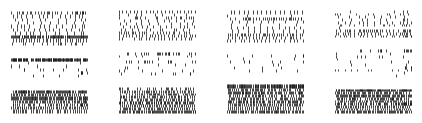

In [119]:
session_name = "hamilton_35"

loader = SpikeTrainLoader(session_name, duration=5.0, max_neurons=10)

trains_first = loader.get_trians_by_type(t_start=0)
trains_second = loader.get_trians_by_type(t_start=600)
trains_third = loader.get_trians_by_type(t_start=1200)
trains_fourth = loader.get_trians_by_type(t_start=1440)


f = plt.figure(figsize=(6, 2))
plot_raster_grouped_time(
    fig=f,
    trains=[trains_first, trains_second, trains_third, trains_fourth],
    type_order=["SR", "SIR", "FF"],
    eventplot_kwargs={"color": "k", "linewidths": 0.8},
)

f.savefig(Config.fig_dir / "Volitility.png", dpi=300, bbox_inches="tight", transparent=True)

### Compare across neuron types

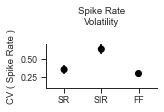

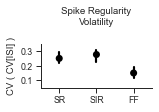

In [172]:
spikes_vol = (
    load_derived_generic("spiketrain_stats_volitility.csv")
    .loc[:, ["neuron_id", "cv_isi", "cv_isi_burst", "mean_firing_rate"]]
    .merge(
        load_derived_generic("neuron_types.csv").loc[
            :, ["neuron_id", "session_name", "neuron_type"]
        ]
    )
)


f_rate = plt.figure(figsize=(2, 0.8))

ax_rate = f_rate.subplots(1, 1)
ax_rate.set_ylim(0.1, 0.7)
sns.pointplot(
    data=spikes_vol,
    x="neuron_type",
    y="mean_firing_rate",
    order=["SR", "SIR", "FF"],
    ax=ax_rate,
    estimator=np.median,
    color="black",
    join=False
)
ax_rate.set_title("Spike Rate\nVolatility", pad=20)
ax_rate.set_ylabel("CV ( Spike Rate )")
ax_rate.set_xlabel("")

sns.despine(fig=f_rate)

f_rate.savefig(Config.fig_dir / "Volatility_rate.png", dpi=300, bbox_inches="tight", transparent=True)

f_reg = plt.figure(figsize=(2, 0.8))
ax_reg = f_reg.subplots(1, 1)
ax_reg.set_ylim(0.05, 0.35)

sns.pointplot(
    data=spikes_vol,
    x="neuron_type",
    y="cv_isi",
    order=["SR", "SIR", "FF"],
    ax=ax_reg,
    estimator=np.median,
    color="black",
    join=False
)
ax_reg.set_title("Spike Regularity\nVolatility", pad=20)
ax_reg.set_ylabel("CV ( CV[ISI] )")
ax_reg.set_xlabel("")

sns.despine(fig=f_reg)
f_reg.savefig(Config.fig_dir / "Volitility_reg.png", dpi=300, bbox_inches="tight", transparent=True)


### Example neuron time series

In [47]:
from binit.bin import which_bin
from drn_interactions.spiketrains.spiketrain_stats import (
    cv_isi_burst,
    cv_isi,
    mean_firing_rate,
)
import warnings


def load_spikes(
    **spikes_handler_kwargs,
):
    spikes_handler = SpikesHandler(**spikes_handler_kwargs)
    return spikes_handler.spikes


def segment_spikes(
    df_spikes,
    segment_length=30,
    t_start=None,
    t_stop=None,
    spiketimes_col="spiketimes",
    neuron_id_col="neuron_id",
    session_name_col="session_name",
):
    if t_start is None:
        t_start = df_spikes[spiketimes_col].min()
    if t_stop is None:
        t_stop = df_spikes[spiketimes_col].max()

    bins = np.arange(t_start, t_stop, segment_length)
    df_spikes["segment"] = which_bin(
        df_spikes[spiketimes_col].values, bins, time_after=segment_length
    )
    return df_spikes


def apply_by_segment(
    df_spikes,
    func,
    segment_col="segment",
    spiketimes_col="spiketimes",
    neuron_id_col="neuron_id",
    returned_colname="result",
):
    by_neuron_segment = df_spikes.groupby(["neuron_id", "segment"])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        apply_result = by_neuron_segment["spiketimes"].apply(func)
    apply_result_frame = apply_result.to_frame(returned_colname).reset_index()
    return apply_result_frame


def neuron_selecter(
    df,
    neuron_type: Optional[str] = None,
    neuron_col: str = "neuron_id",
    type_col: str = "neuron_type",
):
    if neuron_type is None:
        neurons = df[neuron_col].unique()
    else:
        neurons = df.loc[df[type_col] == neuron_type, neuron_col].unique()
    return np.random.choice(neurons, 1)[0]


def plot_neuron_time_series(
    df, 
    neuron, 
    stat_col,
    segment_col="segment",
    neuron_col="neuron_id",
    ax=None,
    t_start=0, 
    t_stop=1800, 
    color="black", 
    linewidth=2,
    **kwargs,
):
    if ax is None:
        f, ax = plt.subplots(1, 1)

    dfp = df.query(f"{neuron_col} == {neuron}").sort_values(segment_col)
    ax.plot(
        dfp[segment_col],
        dfp[stat_col],
        color=color,
        linewidth=linewidth,
        **kwargs,
    )
    sns.despine(ax=ax)
    return ax

In [45]:
session_name = "acute_15"
neuron_types = load_derived_generic("neuron_types.csv")

df_spikes = load_spikes(
    session_names=[session_name], 
    block="pre", 
    bin_width=1,
    )
df_segments = segment_spikes(
    df_spikes, 
    t_start=0, 
    t_stop=1800,
    segment_length=30
    )
reg_by_segment = apply_by_segment(
    df_segments, 
    func=cv_isi_burst,
    returned_colname="CV[ISI]"
)
rate_by_segment = apply_by_segment(
    df_segments, 
    func=mean_firing_rate,
    returned_colname="Spike Rate"
)
df_res = (
    reg_by_segment
    .merge(rate_by_segment)
    .merge(neuron_types[["neuron_id", "neuron_type"]])
)

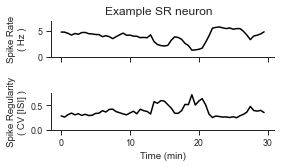

In [108]:
# neuron_to_plot = neuron_selecter(df_res, neuron_type="SR")
neuron_to_plot = 2301
# neuron_to_plot = 2299

f = plt.figure(figsize=(4, 2),)
ax_rate, ax_reg = f.subplots(2,  sharex=True, gridspec_kw={"hspace": 1})
plot_neuron_time_series(
    df=df_res,
    neuron=neuron_to_plot,
    stat_col="Spike Rate",
    ax=ax_rate,
    linewidth=1.5,
    label=neuron_to_plot
)
plot_neuron_time_series(
    df=df_res,
    neuron=neuron_to_plot,
    stat_col="CV[ISI]",
    ax=ax_reg,
    linewidth=1.5,
    label=neuron_to_plot
)
ax_reg.set_xticks([0, 600, 1200, 1800])
ax_reg.set_xticklabels((ax_reg.get_xticks() / 60).astype(int))
ax_reg.set_ylim(0, 0.75)
ax_rate.set_ylim(0, 7)
ax_rate.set_ylabel("Spike Rate\n( Hz )")
ax_reg.set_ylabel("Spike Regularity\n( CV [ISI] )")
ax_reg.set_xlabel("Time (min)")

f.align_ylabels()
f.suptitle("Example SR neuron")

f.savefig(Config.fig_dir / "Example neuron volatility time series.png", dpi=300, bbox_inches="tight")


In [85]:
def get_spikes_at_time(
    df_spikes,
    t_start: float,
    neuron: Any,
    duration: float = 5.0,
    spiketimes_col="spiketimes",
    neuron_id_col="neuron_id",
):
    return (
        df_spikes
        .query(f"{neuron_id_col} == {neuron}")
        .query(f"{spiketimes_col} >= {t_start}")
        .query(f"{spiketimes_col} < {t_start + duration}")
    )[spiketimes_col].values


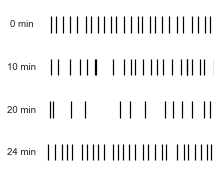

In [107]:
time_points = np.array([0, 10, 20, 24]) * 60
spike_trains = [
    get_spikes_at_time(df_spikes, t, neuron_to_plot) for t in time_points
]

f = plt.figure(figsize=(3, 3))
axes = f.subplots(len(spike_trains), 1)

for ax, spikes, t in zip(axes, spike_trains, time_points):
    ax.eventplot(spikes, color="black")
    ax.set_xlim(t, t + 5)
    ax.set_yticks([])
    ax.set_xticks([])
    time_in_mins = int(t / 60)
    ax.set_ylabel(f"{time_in_mins} min", rotation=0, labelpad=20, va="center")

sns.despine(f, bottom=True, left=True)
f.align_ylabels()


f.savefig(Config.fig_dir / "Example neuron volatility rasters.png", dpi=300, bbox_inches="tight")
# f.show()